In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data
train_data = datasets.FashionMNIST(
    root='./fashiondata',
    train=True,
    download=True,
    transform=ToTensor()
)

#  download test data
test_data = datasets.FashionMNIST(
    root='./fashiondata',
    train=False,
    download=True,
    transform=ToTensor()
)

In [99]:
batch_size = 6

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([6, 1, 28, 28])
Shape of y: torch.Size([6]) torch.int64


In [100]:
# Get cpu or gpu device for training 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} for training")

# output the device info
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"Memory Usage: {torch.cuda.memory_allocated(0) / 1024**3:.3f} GB")
    print(f"Cuda version: {torch.version.cuda}")
    print(f"Cudnn version: {torch.backends.cudnn.version()}")

Using cuda for training
Device: NVIDIA GeForce GTX 980 Ti
Memory Usage: 0.011 GB
Cuda version: 11.6
Cudnn version: 8302


In [101]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [106]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [107]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        pred = model.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:<5d}]")


In [108]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [109]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done training")

Epoch 1
--------------------------------
loss: 1.244875 [    0/60000]
loss: 0.912305 [  600/60000]
loss: 1.633523 [ 1200/60000]
loss: 0.424719 [ 1800/60000]
loss: 2.170732 [ 2400/60000]
loss: 1.218477 [ 3000/60000]
loss: 1.185403 [ 3600/60000]
loss: 0.129139 [ 4200/60000]
loss: 0.721709 [ 4800/60000]
loss: 0.759470 [ 5400/60000]
loss: 0.687891 [ 6000/60000]
loss: 0.624871 [ 6600/60000]
loss: 0.853191 [ 7200/60000]
loss: 0.765871 [ 7800/60000]
loss: 0.181301 [ 8400/60000]
loss: 0.220630 [ 9000/60000]
loss: 0.789909 [ 9600/60000]
loss: 0.496688 [10200/60000]
loss: 0.503745 [10800/60000]
loss: 0.271242 [11400/60000]
loss: 0.567298 [12000/60000]
loss: 0.618639 [12600/60000]
loss: 0.886782 [13200/60000]
loss: 0.447342 [13800/60000]
loss: 0.142310 [14400/60000]
loss: 0.667118 [15000/60000]
loss: 0.064065 [15600/60000]
loss: 0.102207 [16200/60000]
loss: 1.028983 [16800/60000]
loss: 0.146481 [17400/60000]
loss: 1.200664 [18000/60000]
loss: 0.104033 [18600/60000]
loss: 0.344884 [19200/60000]
lo

In [110]:
torch.save(model.state_dict(), "model.pth")
print("Model saved")

Model saved


5234
Predicted: "Sneaker", Actual: Sneaker


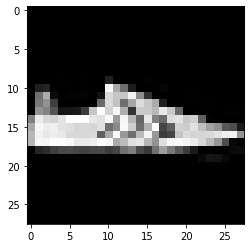

: 

In [122]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# pic random number
import random
rand_sample = int(random.random() * test_data.__len__())
print(rand_sample)

model.eval()
x, y = test_data[rand_sample][0], test_data[rand_sample][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: {actual}')

import matplotlib.pyplot as plt
#show image
plt.imshow(x.T.rot90().rot90().rot90(), cmap='gray')